# Excess deaths due to COVID-19

In [1]:
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2020-01-01")
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


The columns are:

* `date` + `year`: self explanatory
* `month`: month, numerically encoded. Needs to be treated as a categorical variable
* `temp`: average UK temperature (Celsius)
* `t`: time
* `pre`: boolean flag indicating pre or post intervention

## Run the analysis

In this example we are going to standardize the data. So we have to be careful in how we interpret the inferred regression coefficients, and the posterior predictions will be in this standardized space.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


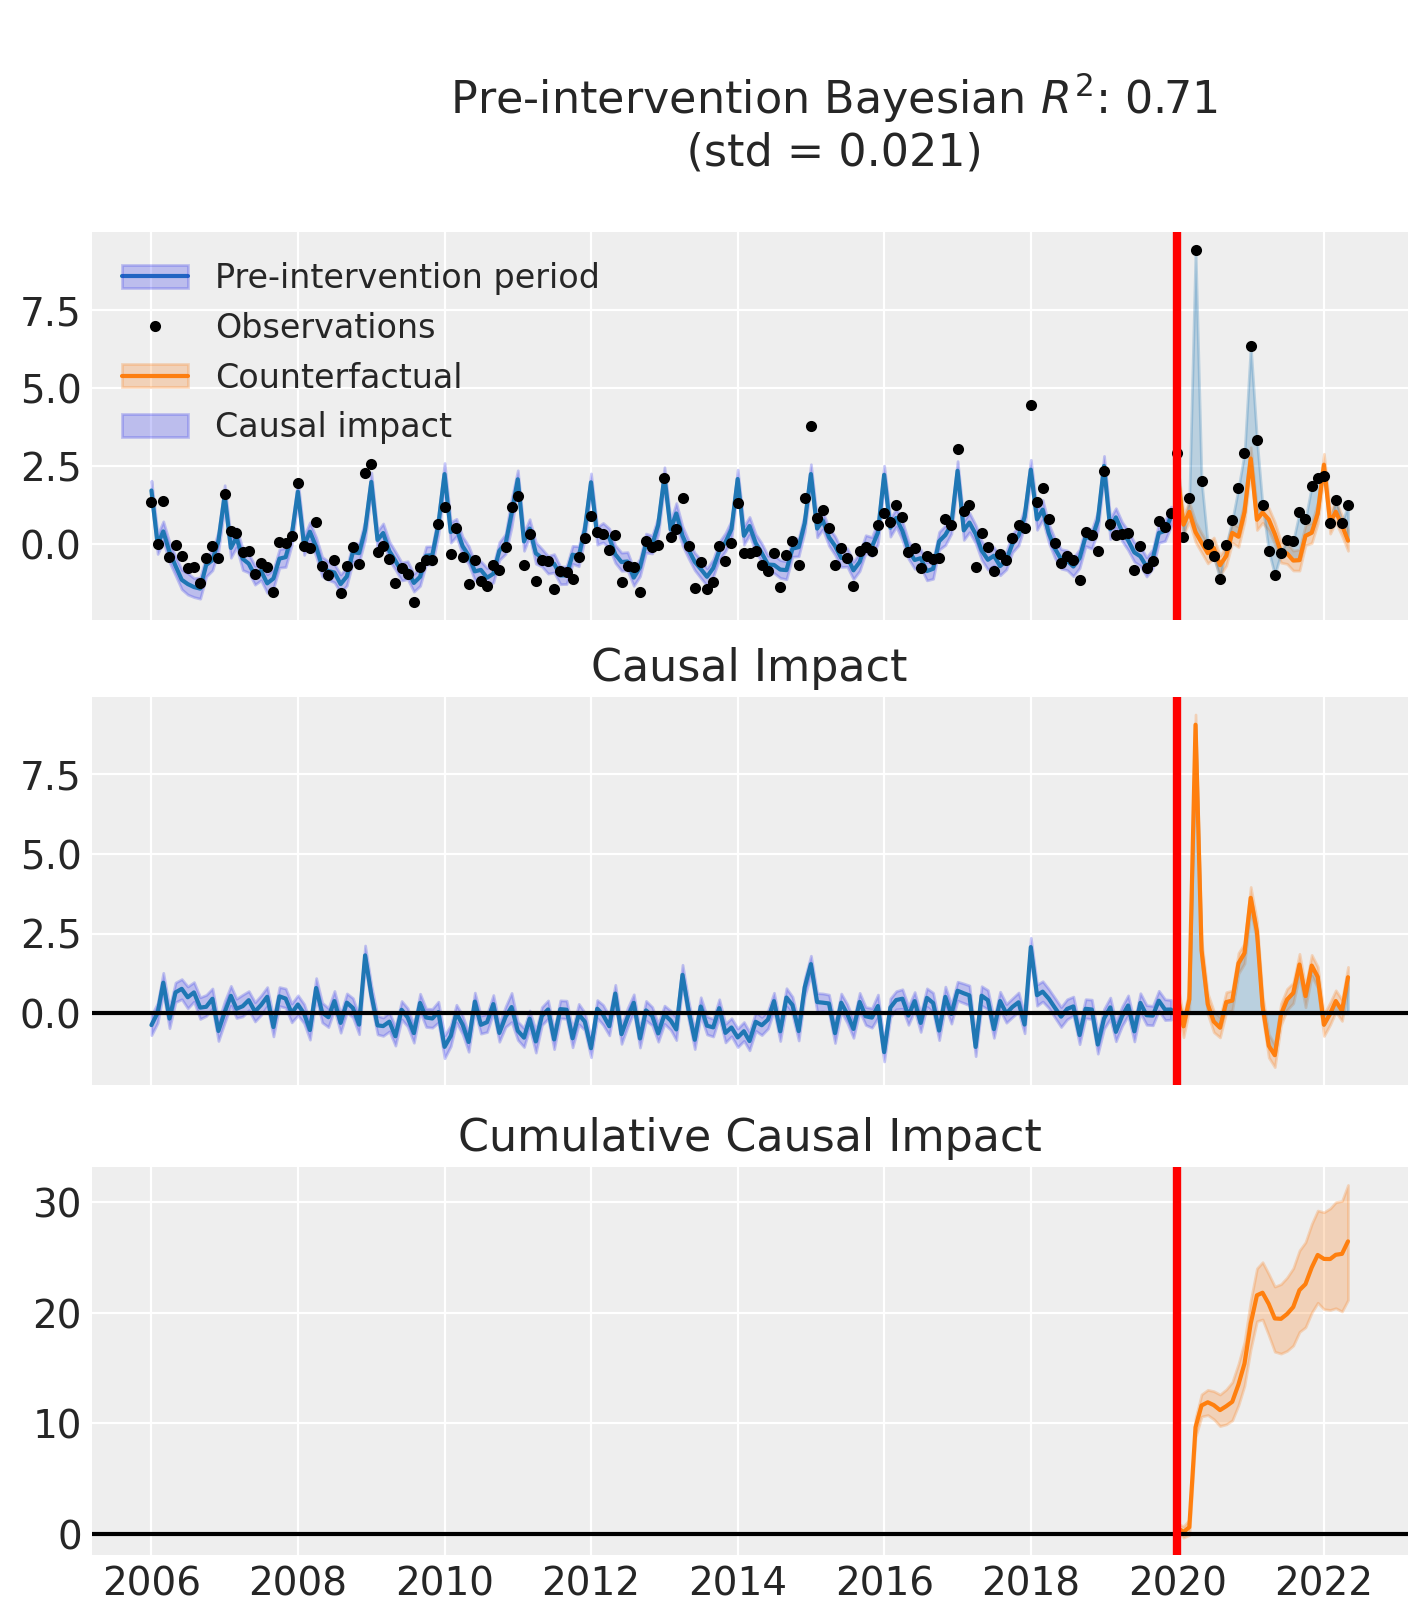

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)
Model coefficients:
    C(month)[1]        1.6, 94% HDI [1.1, 2]
    C(month)[2]        -0.2, 94% HDI [-0.64, 0.25]
    C(month)[3]        0.26, 94% HDI [-0.11, 0.64]
    C(month)[4]        -0.035, 94% HDI [-0.33, 0.26]
    C(month)[5]        -0.15, 94% HDI [-0.45, 0.15]
    C(month)[6]        -0.22, 94% HDI [-0.62, 0.2]
    C(month)[7]        -0.025, 94% HDI [-0.54, 0.49]
    C(month)[8]        -0.42, 94% HDI [-0.9, 0.045]
    C(month)[9]        -0.45, 94% HDI [-0.82, -0.06]
    C(month)[10]       -0.058, 94% HDI [-0.34, 0.23]
    C(month)[11]       -0.36, 94% HDI [-0.69, -0.021]
    C(month)[12]       0.076, 94% HDI [-0.34, 0.51]
    standardize(t)     0.23, 94% HDI [0.15, 0.31]
    standardize(temp)  -0.44, 94% HDI [-0.74, -0.15]
    y_hat_sigma        0.55, 94% HDI [0.5, 0.62]


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects. This gives you a CausalImpact-style summary without manual post-processing.

:::{note}
Note that in this example, the data has been standardized, so the effect estimates are in standardized units. When interpreting the results, keep in mind that the effects are relative to the standardized scale of the outcome variable.
:::


In [7]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,0.913080,0.915239,0.730235,1.107721,1.0,181.148029,85.906924,288.197309
cumulative,26.479315,26.541928,21.176827,32.123920,1.0,181.148033,85.906925,288.197316


In [8]:
# View the prose summary
print(stats.text)

Post-period (2020-01-01 00:00:00 to 2022-05-01 00:00:00), the average effect was 0.91 (95% HDI [0.73, 1.11]), with a posterior probability of an increase of 1.000. The cumulative effect was 26.48 (95% HDI [21.18, 32.12]); probability of an increase 1.000. Relative to the counterfactual, this equals 181.15% on average (95% HDI [85.91%, 288.20%]).


In [9]:
# You can also analyze a specific time window, e.g., the first 6 months of 2020
stats_window = result.effect_summary(
    window=(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-06-30"))
)
stats_window.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,1.986129,1.986069,1.793216,2.190517,1.0,293.850773,188.686022,418.687563
cumulative,11.916776,11.916415,10.759296,13.143105,1.0,293.850776,188.686024,418.687570
